# Previsão de Engajamento - Classificação

In [1]:
#@title Importações de pacote
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
BASE_PATH = 'dados/'

In [3]:
#@title Definições Auxiliares
class Identity(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X):
        return self

    def transform(self, X):
        return X

    def fit_transform(self, X, y=None):
        return X

# 1 - Carrega os Dados

Carregando dados brutos.

In [4]:
dfx = pd.read_excel(BASE_PATH + 'bolsonaro-preproc2-inputs.xlsx', index_col='ID')
dfx.head()


,Dispositivo Retórico,Main character,Retórica Aristotélica,Tipo de conteúdo,Texto / Hashtag,Tonalidade,Abordagem,Duracao
ID,,,,,,,,
7114971700365691904,Political Statement,Self alone,Pathos,Campaign Act,Hashtag,Neutral,Acclamation,57.93
7115050482179050496,Fact/Statistic,Self alone,Logos,Political-Purposeful,Hashtag,Positive,Acclamation,17.13
7115120078982631424,Commitment,Self + voters,Ethos,Political-Purposeful,Hashtag,Positive,Acclamation,52.54
7115161088219565056,Humor,Self alone,Nenhum,Personal,Hashtag,Positive,Acclamation,34.48
7115207919750253568,Fact/Statistic,Self alone,Logos,Political-Purposeful,Hashtag,Negative,Attack,66.66


In [5]:
dfy = pd.read_excel(BASE_PATH + 'bolsonaro-preproc2-outputs.xlsx', index_col='ID')
dfy.head()

,Curtidas,Curtidas-Log,Curtidas-4Classes,Curtidas-2Classes
ID,,,,
7114971700365691904,24400,10.102338,medium-low,0
7115050482179050496,9163,9.122929,low,0
7115120078982631424,3485,8.156223,low,0
7115161088219565056,22100,10.003333,medium-low,0
7115207919750253568,115700,11.658756,high,1


In [6]:
df_merged = pd.merge(dfx, dfy, on="ID", how="inner")

In [7]:
df_merged

,Dispositivo Retórico,Main character,Retórica Aristotélica,Tipo de conteúdo,Texto / Hashtag,Tonalidade,Abordagem,Duracao,Curtidas,Curtidas-Log,Curtidas-4Classes,Curtidas-2Classes
ID,,,,,,,,,,,,
7114971700365691904,Political Statement,Self alone,Pathos,Campaign Act,Hashtag,Neutral,Acclamation,57.93,24400,10.102338,medium-low,0
7115050482179050496,Fact/Statistic,Self alone,Logos,Political-Purposeful,Hashtag,Positive,Acclamation,17.13,9163,9.122929,low,0
7115120078982631424,Commitment,Self + voters,Ethos,Political-Purposeful,Hashtag,Positive,Acclamation,52.54,3485,8.156223,low,0
7115161088219565056,Humor,Self alone,Nenhum,Personal,Hashtag,Positive,Acclamation,34.48,22100,10.003333,medium-low,0
7115207919750253568,Fact/Statistic,Self alone,Logos,Political-Purposeful,Hashtag,Negative,Attack,66.66,115700,11.658756,high,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7159766081593151488,Endorsement,Nenhum,Ethos,Campaign Act,Hashtag,Positive,Acclamation,74.16,95300,11.464785,high,0
7159773640030997504,Humor,Self + opponent,Ethos,Nenhum,Texto + Hashtag,Neutral,Attack,5.32,240900,12.392137,high,1
7159891102143631360,Humor,Self + opponent,Nenhum,Nenhum,Hashtag,Neutral,Attack,7.73,109600,11.604593,high,1


In [8]:
#classes_str = ['low', 'medium-low', 'medium-high', 'high']
#dfy = df['Curtidas-4Classes'].apply(lambda x: classes_str.index(x))

classes_str = ['LOW', 'HIGH']
dfy = dfy['Curtidas-2Classes']
dfy.head()

ID
7114971700365691904    0
7115050482179050496    0
7115120078982631424    0
7115161088219565056    0
7115207919750253568    1
Name: Curtidas-2Classes, dtype: int64

# 2 - Separação dos Dados

Dados que serão usados para a otimização de parâmetros com o *grid search*.

(No momento, estou usando *todos* os dados.)

In [9]:
#smote = SMOTE(random_state=42, k_neighbors=3)

#dfx_grid, dfy_grid = smote.fit_resample(dfx, dfy)

In [10]:
# divide os dados em treino e teste, de forma estratificada (preservando a proporção entre as classes)
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, stratify=dfy, random_state=42)

In [11]:
# TODO: remover essas variáveis
dfx_grid = X_train  #dfx
dfy_grid = y_train  #dfy

# 3 - Grid Search com Vários Modelos

In [12]:
from sklearn.base import clone
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # SMOTE não funciona com o Pipeline do scikit-learn

In [13]:
CATEGORICAL_COLS = ['Dispositivo Retórico', 'Main character', 'Retórica Aristotélica', 'Tipo de conteúdo',
                    'Texto / Hashtag', 'Tonalidade', 'Abordagem']

Conjunto de transformações que serão aplicadas nos dados:

In [18]:
# This is necessary to allow encoding training and/or test data correctly
CATEGORIES = [dfx[col].unique() for col in CATEGORICAL_COLS]

def one_hot_encoder():
   _transf_o=[
        ('cat', OneHotEncoder(categories=CATEGORIES, drop='first', sparse_output=False), CATEGORICAL_COLS)]
   return ColumnTransformer(transformers=_transf_o, remainder='passthrough')

def target_encoder1():
    _transf_t1=[
        ('cat', TargetEncoder(shuffle=False, target_type='binary'), CATEGORICAL_COLS)]
    return ColumnTransformer(transformers=_transf_t1, remainder='passthrough')


# TEM QUE PRE-TREINAR, COMO FAZER? 
# TODO: criar classe especial, que tem acesso prévio interno ao y
# FAZ UM JOIN PELO INDEX e APLICA ???
#_transf_t2=[
#        ('cat', TargetEncoder(shuffle=False, target_type='continuous'), CATEGORICAL_COLS)]
#targetenc2 = ColumnTransformer(transformers=_transf_t2, remainder='passthrough')

#_transf_t3=[
        #('cat', TargetEncoder(shuffle=False, target_type='continuous'), CATEGORICAL_COLS)]
#targetenc2 = ColumnTransformer(transformers=_transf_t3, remainder='passthrough')

In [19]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

In [20]:
def treinamento_modelo(estimador, X_train, y_train):
    """
    Treina um modelo com os dados de treinamento.

    Args:
        estimador: Um modelo de aprendizado de máquina (classificador/regressor).
        X_train: Dados de treinamento.
        y_train: Rótulos de treinamento.

    Returns:
        estimador_treinado: O modelo treinado.
        tempo_treinamento: O tempo de treinamento em segundos.
    """
    inicio_treinamento = time.time()
    estimador_treinado = estimador.fit(X_train, y_train)
    fim_treinamento = time.time()
    tempo_treinamento = fim_treinamento - inicio_treinamento
    return estimador_treinado, tempo_treinamento

def analise_modelos(lista_modelos, X, y):
    """
    Esta função treina vários modelos e avalia seu desempenho usando métricas como acurácia, precisão, revocação e F1-score.
    Também plota a curva ROC-AUC e a matriz de confusão para cada modelo.

    Args:
        lista_modelos: Uma lista de dicionários contendo informações sobre os modelos a serem treinados.
        X: Conjunto de dados.
        y: Rótulos.

    Returns:
        dict: Um dicionário com as métricas de desempenho de cada modelo.
    """

    print(f"\n\n\n **** RESULTADO DOS MODELOS + CURVA ROC-AUC ****\n")

    # Lista para armazenar os valores de fpr e tpr de cada modelo (para a curva ROC)
    roc_fpr_list = []
    roc_tpr_list = []

    # Lista para armazenar os valores de precision e recall de cada modelo (para a curva PR)
    pr_precision_list = []
    pr_recall_list = []
        
    # Configurando a validação cruzada externa
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    resultados_iteracao = {}  # Dicionário para armazenar os resultados desta iteração

    # Configurando a busca em grade dentro de cada iteração da validação cruzada externa
    for mdl in lista_modelos:
        nome_do_modelo = mdl["nome_do_modelo"]
        estimador = mdl.get('estimador')
        parametros = mdl.get('parametros')

        # Listas para armazenar métricas de interesse em cada fold
        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_score_list = []
        auc_score_list = []
        aucpr_score_list = []

        # Configurando a busca em grade
        # com 'precision' - resultados ruins
        grid_search = GridSearchCV(estimador, parametros, scoring='f1', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1)

        print(f"Treinando modelo {nome_do_modelo}", end="")

        # Executando a validação cruzada
        tempos_de_treinamento = []
        best_model_params = []
        for train_ix, test_ix in cv_outer.split(X, y):
            print(".", end="")
            X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
            y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

            # Capturando tempo de treinamento
            modelo_treinado, tempo_treinamento = treinamento_modelo(grid_search, X_train, y_train)
            best_model_params.append(modelo_treinado.best_params_)
            tempos_de_treinamento.append(tempo_treinamento)

            # Avaliação do modelo (com os melhores parâmetros encontrados) no conjunto de teste
            y_pred = modelo_treinado.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            # Armazenando métricas deste fold
            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_score_list.append(f1)

            y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
            
            auc_score = metrics.roc_auc_score(y_test, y_pred_proba)  # Calcula AUC
            auc_score_list.append(auc_score)
            # sobre aucPR
            # https://datascience.stackexchange.com/questions/9003/when-do-i-have-to-use-aucpr-instead-of-auroc-and-vice-versa
            aucpr_score = metrics.average_precision_score(y_test, y_pred_proba)  # Calcula AUC-PR
            aucpr_score_list.append(aucpr_score)

            # Valores para a curva PR
            precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba)  # Calcula Precision e Recall
            pr_precision_list.append(precision)
            pr_recall_list.append(recall)

            # Valores para a curva ROC
            fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)  # Calcula FPR e TPR
            roc_fpr_list.append(fpr)
            roc_tpr_list.append(tpr)
        
        print()

        # Calculando as médias e desvios padrão das métricas
        accuracy_mean = np.mean(accuracy_list)
        accuracy_std = np.std(accuracy_list)
        precision_mean = np.mean(precision_list)
        precision_std = np.std(precision_list)
        recall_mean = np.mean(recall_list)
        recall_std = np.std(recall_list)
        f1_score_mean = np.mean(f1_score_list)
        f1_score_std = np.std(f1_score_list)

        auc_mean = np.mean(auc_score_list)
        auc_std = np.std(auc_score_list)
        aucpr_mean = np.mean(aucpr_score_list)
        aucpr_std = np.std(aucpr_score_list)

        print(f"Modelo     : {nome_do_modelo}")
        print(f"Acurácia   : {accuracy_mean:.5f} +/- {accuracy_std:.5f}")
        print(f"Precisão   : {precision_mean:.5f} +/- {precision_std:.5f}")
        print(f"Revocação  : {recall_mean:.5f} +/- {recall_std:.5f}")
        print(f"F1 - Score : {f1_score_mean:.5f} +/- {f1_score_std:.5f}")
        print(f"ROC - AUC  : {auc_mean:.5f} +/- {auc_std:.5f}")
        print(f"PR - AUC   : {aucpr_mean:.5f} +/- {aucpr_std:.5f}")
        print(f"Tempo médio de treinamento: {np.mean(tempos_de_treinamento):.5f} segundos\n\n{'='*50}\n")

        resultados_iteracao[mdl.get('nome_do_modelo')]  = {
        #resultados_iteracao[nome_do_modelo]  = {
            "Acurácia_mean": accuracy_mean,
            "Acurácia_std": accuracy_std,
            "Precisão_mean": precision_mean,
            "Precisão_std": precision_std,
            "Revocação_mean": recall_mean,
            "Revocação_std": recall_std,
            "f1_score_mean": f1_score_mean,
            "f1_score_std": f1_score_std,
            "auc_mean": auc_mean,
            "auc_std": auc_std,
            "aucpr_mean": aucpr_mean,
            "aucpr_std": aucpr_std,
            "tempo_medio_treinamento": np.mean(tempos_de_treinamento),
            "melhores_parametros": best_model_params,
        }

    # Plotagem da curva ROC geral
    plt.figure(figsize=(10, 8))  # Ajusta o tamanho da figura
    for fpr, tpr, mdl in zip(roc_fpr_list, roc_tpr_list, lista_modelos):
        plt.plot(fpr, tpr, label='%s ROC' % mdl["nome_do_modelo"])
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('CURVA ROC-AUC')
    plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0))  # Posiciona a legenda
    plt.show()

    # Plotagem da curva PR geral
    plt.figure(figsize=(10, 8))  # Ajusta o tamanho da figura
    for precision, recall, mdl in zip(pr_precision_list, pr_recall_list, lista_modelos):
        plt.plot(recall, precision, label='%s PR' % mdl["nome_do_modelo"])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('CURVA PR')
    plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0))  # Posiciona a legenda
    plt.show()

    return resultados_iteracao

In [21]:
#from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingRegressor

lista_modelos = [
    {
        "nome_do_modelo": 'Logist Regression',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('smote', SMOTE(random_state=42)),
            ('scaler', StandardScaler()), 
            ('logreg', LogisticRegression())
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(), target_encoder1()],
            'smote': [SMOTE(random_state=42), SMOTE(random_state=42,k_neighbors=3)],
            'scaler': [Identity(), StandardScaler(with_mean=True), StandardScaler(with_mean=False), MinMaxScaler()],
            'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],   # Regularization parameter
            'logreg__solver': ['liblinear', 'saga'],       # Solver for optimization
            'logreg__penalty': ['l1', 'l2']                # Penalty term
        }
    },
    {
        "nome_do_modelo": 'Decision Tree',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('smote', SMOTE(random_state=42)),
            ('tree', DecisionTreeClassifier())
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(), target_encoder1()],
            'smote': [SMOTE(random_state=42), SMOTE(random_state=42,k_neighbors=3)],
            'tree__max_depth': [5, 15, 20], 
            'tree__min_samples_split': [5, 10, 15], 
            'tree__min_samples_leaf': [1, 2, 5], 
            'tree__max_features': ['sqrt', 'log2']
        }
    },
    {
        "nome_do_modelo": 'KNN',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('smote', SMOTE(random_state=42)),
            ('scaler', StandardScaler()), 
            ('knn', KNeighborsClassifier())
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(), target_encoder1()],
            'smote': [SMOTE(random_state=42), SMOTE(random_state=42,k_neighbors=3)],
            'scaler': [Identity(), StandardScaler(with_mean=True), StandardScaler(with_mean=False), MinMaxScaler()], 
            'knn__n_neighbors': [3, 7, 15], 
            'knn__weights': ['uniform', 'distance'], 
            'knn__p': [1, 2]
        }
    },
    {
        "nome_do_modelo": 'Random Forest',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('smote', SMOTE(random_state=42)),
            ('forest', RandomForestClassifier())
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(), target_encoder1()],
            'smote': [SMOTE(random_state=42), SMOTE(random_state=42,k_neighbors=3)],
            'forest__n_estimators': [5, 10, 20], 
            'forest__max_depth': [5, 10, 15],
            'forest__min_samples_split': [2, 5, 10],
            'forest__min_samples_leaf': [1, 2, 5],
            'forest__max_features': ['sqrt', 'log2']
        }
    },
]
    #{
    #    "nome_do_modelo": "XGBoost",
    #    "estimador": XGBClassifier(),
    #    "parametros": {'max_depth': [3, 5, 7]}
    #},
    # {
    #     "nome_do_modelo": 'Support Vector Machine',
    #     "estimador": SVC(),
    #     "parametros": {'C': [0.1, 10, 50, 100], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf', 'sigmoid']}
    # },
    # {
    #     "nome_do_modelo": 'Gradient Boosting',
    #     "estimador": GradientBoostingRegressor(),
    #     "parametros": {'n_estimators': [20, 40, 60], 'max_depth': [2, 5, 10], 'learning_rate': [0.01, 0.1, 0.2, 0.3], 'loss': ['squared_error', 'absolute_error', 'huber']}
    # },
#]




 **** RESULTADO DOS MODELOS + CURVA ROC-AUC ****

Treinando modelo Logist Regression.

....
Modelo     : Logist Regression
Acurácia   : 0.70174 +/- 0.04270
Precisão   : 0.36154 +/- 0.08352
Revocação  : 0.42444 +/- 0.15111
F1 - Score : 0.38321 +/- 0.09701
ROC - AUC  : 0.67851 +/- 0.06136
PR - AUC   : 0.36494 +/- 0.03837
Tempo médio de treinamento: 4.09151 segundos


Treinando modelo Decision Tree.....
Modelo     : Decision Tree
Acurácia   : 0.69199 +/- 0.03479
Precisão   : 0.24667 +/- 0.07180
Revocação  : 0.17111 +/- 0.05425
F1 - Score : 0.19877 +/- 0.05646
ROC - AUC  : 0.55266 +/- 0.05746
PR - AUC   : 0.27842 +/- 0.01749
Tempo médio de treinamento: 1.67896 segundos


Treinando modelo KNN.....
Modelo     : KNN
Acurácia   : 0.63426 +/- 0.11620
Precisão   : 0.32908 +/- 0.11540
Revocação  : 0.49111 +/- 0.17756
F1 - Score : 0.38231 +/- 0.12268
ROC - AUC  : 0.64084 +/- 0.08577
PR - AUC   : 0.32659 +/- 0.06881
Tempo médio de treinamento: 2.18592 segundos


Treinando modelo Random Forest.....
Modelo     : Random Forest
Acurácia   : 0.66341 +/- 0.04004
Precisão   : 0.25000 +/- 0.

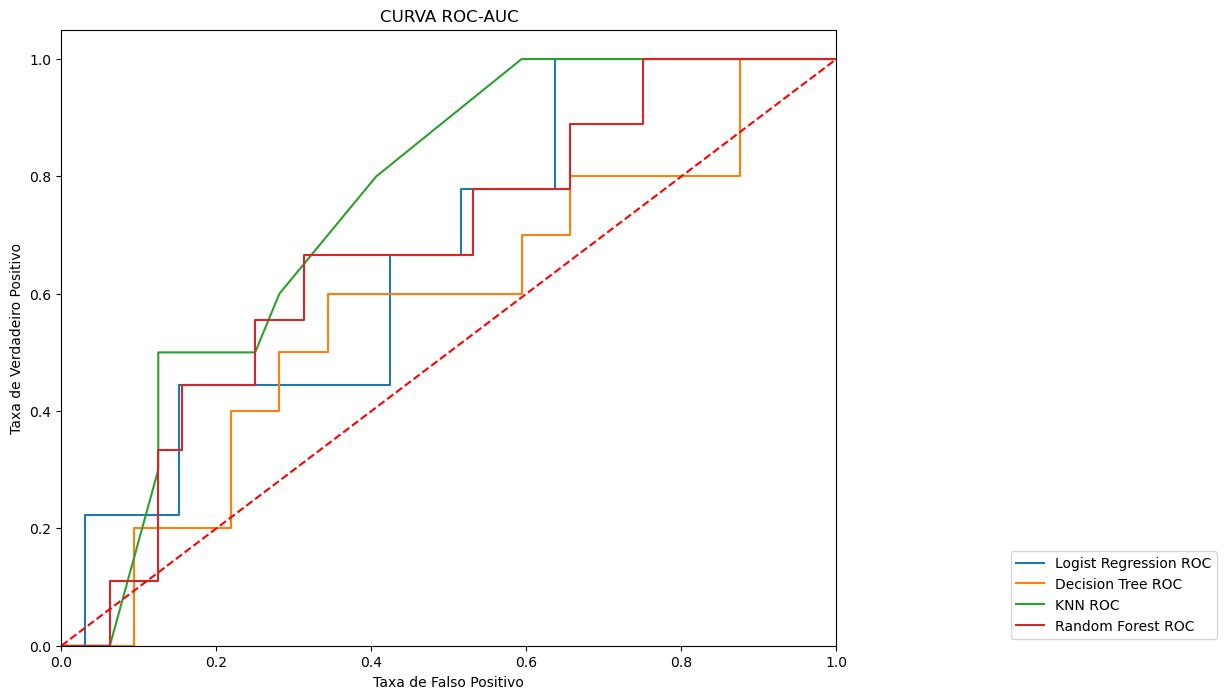

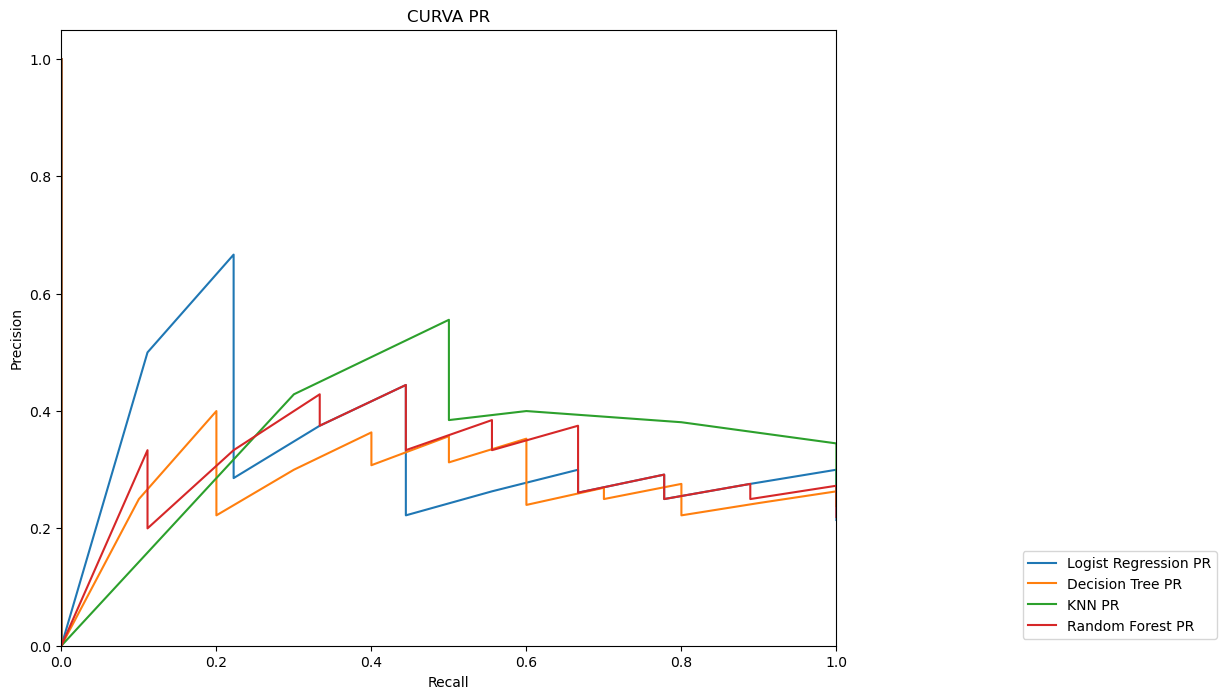

In [22]:
result = analise_modelos(lista_modelos, dfx_grid, dfy_grid)

In [23]:
# IDEIA: fazer código para pegar a parametrização majoritária
#result['Decision Tree']['melhores_parametros']

# 3 - Estimando os Atributos Mais Importantes


- Atributos mais altos na árvore
- Atributos mais usados nos nós da árvore
- Valor de 'feature_importances_' calculado no modelo

In [24]:
#@title Definições auxiliares (não precisa abrir)
from sklearn.tree import plot_tree
import numpy as np
import matplotlib.pyplot as plt

def plot_importance(model, max_features=None, feature_names=None, sort=True, ax=None):
    """
    Plot feature importances for a scikit-learn random forest or gradient boosting model.

    Parameters
    ----------
    model : object
        A scikit-learn random forest or gradient boosting model.
    max_features : int or None, optional (default=None)
        The maximum number of features to plot. If None, plot all features.
    feature_names : list or None, optional (default=None)
        A list of feature names to use in the plot. If None, use the feature indices.
    sort : bool, optional (default=True)
        Whether to sort the feature importances in descending order.
    ax : matplotlib.axes.Axes or None, optional (default=None)
        The matplotlib axes to plot the feature importances on. If None, create a new figure and axes.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The matplotlib axes containing the plot.

    """
    # Extract feature importances
    importances = model.feature_importances_

    # Get feature names
    if feature_names is None:
        feature_names = [str(i) for i in range(len(importances))]

    # Sort feature importances
    if sort:
        indices = np.argsort(importances)[::-1]
        importances = importances[indices]
        feature_names = [feature_names[i] for i in indices]

    # Truncate feature importances
    if max_features is not None:
        importances = importances[:max_features]
        feature_names = feature_names[:max_features]

    # Create plot
    if ax is None:
        fig, ax = plt.subplots()
    ax.barh(np.arange(len(importances)), importances, align='center')
    ax.set_yticks(np.arange(len(importances)))
    ax.set_yticklabels(feature_names)
    ax.set_xlabel('Feature importance')
    ax.invert_yaxis()

    return ax


In [41]:
# obtém os parâmetros obtidos no grid search no 1o fold
dec_tree_params = result['Decision Tree']['melhores_parametros'][0]
dec_tree_pipeline = lista_modelos[1]['estimador'].set_params(**dec_tree_params)

In [42]:
dec_tree_pipeline.fit(dfx_grid, dfy_grid)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(categories=[array(['Political Statement', 'Fact/Statistic', 'Commitment', 'Humor',
       'Nenhum', 'Opinion', 'Endorsement', 'Thanks', 'Urgency',
       'Advertisement', 'Personal Appeal', 'Collective Appeal',
       'Call to Action'], dtype=object),
                                                                            array(['Self alone', 'Self + voters', '...
                                                                            array(['Acclamation', 'Attack', 'Defense'], dtype=object)],
                                                                drop='first',
                                                                sparse_output=False),
                                                  ['Dispositivo Retórico',
                                                   'Main character',
                                                   'Retórica Aristotélica',
                                                   'Tipo de conteúdo',
                                                   'Texto / Hashtag',
                                                   'Tonalidade',
                                                   'Abordagem'])])),
                ('smote', SMOTE(random_state=42)),
                ('tree',
                 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                                        min_samples_leaf=5,
                                        min_samples_split=10))])

In [43]:
# take the decision tree model inside the pipeline
dec_tree = dec_tree_pipeline.named_steps['tree']

#fig = plt.figure(figsize=(22,15))
#plot_tree(dec_tree, feature_names=list(dfx_grid.columns), filled=True);

In [44]:
rforest_params = result['Random Forest']['melhores_parametros'][0]
rforest_pipeline = lista_modelos[3]['estimador'].set_params(**rforest_params)

In [45]:
rforest_pipeline.fit(dfx_grid, dfy_grid)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(categories=[array(['Political Statement', 'Fact/Statistic', 'Commitment', 'Humor',
       'Nenhum', 'Opinion', 'Endorsement', 'Thanks', 'Urgency',
       'Advertisement', 'Personal Appeal', 'Collective Appeal',
       'Call to Action'], dtype=object),
                                                                            array(['Self alone', 'Self + voters', '...
                                                                            array(['Acclamation', 'Attack', 'Defense'], dtype=object)],
                                                                drop='first',
                                                                sparse_output=False),
                                                  ['Dispositivo Retórico',
                                                   'Main character',
                                                   'Retórica Aristotélica',
                                                   'Tipo de conteúdo',
                                                   'Texto / Hashtag',
                                                   'Tonalidade',
                                                   'Abordagem'])])),
                ('smote', SMOTE(k_neighbors=3, random_state=42)),
                ('forest',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=5))])

In [46]:
rf = rforest_pipeline.named_steps['forest']
#pd.DataFrame({'features' : df_x.columns[2:], 'feature_importance' : rf.feature_importances_}).sort_values(by='feature_importance', ascending=False)

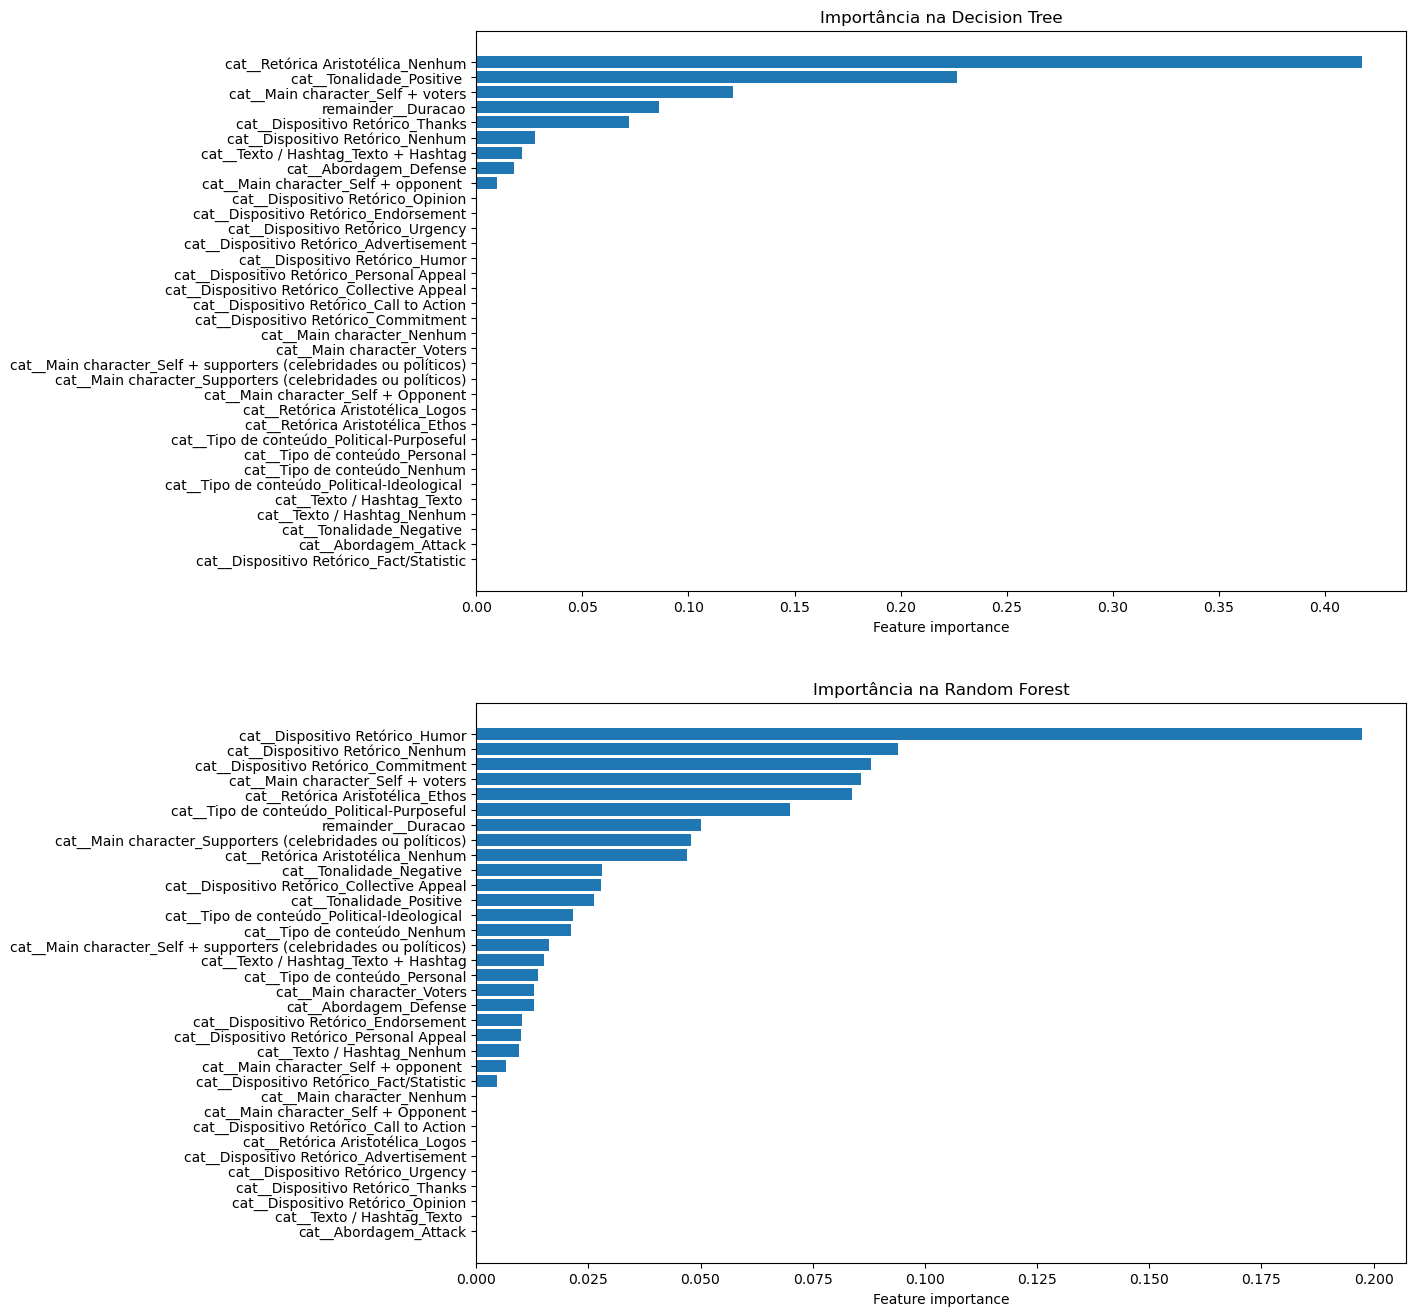

In [47]:
# plot the feature importances
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].set_title('Importância na Decision Tree')
features = dec_tree_pipeline.named_steps['preproc'].get_feature_names_out()
plot_importance(dec_tree, feature_names=features, ax=ax[0])

ax[1].set_title('Importância na Random Forest')
features = rforest_pipeline.named_steps['preproc'].get_feature_names_out()
plot_importance(rf, feature_names=features, ax=ax[1])
plt.show()

# 4 - Treinamento e Avaliação do Modelo Final

Recomendações para decidir quantos dados usar para treinar o modelo final:

1. É importante considerar o **equilíbrio entre *bias* e variância**. 
  - usar todos os dados disponíveis para treinar o modelo pode aumentar o **bias** (viés) do modelo;
  - usar apenas parte dos dados pode aumentar a **variância** do modelo. 

2. Em geral, é recomendável usar a **maior quantidade** de dados possível para treinar o modelo final, desde que isso não comprometa a capacidade do modelo de generalizar para novos dados. 

3. Pode ser útil usar a validação cruzada para avaliar o desempenho do modelo com diferentes quantidades de dados e escolher o modelo que tenha o melhor equilíbrio entre bias e variância. (Estamos fazendo isso na escolha do melhor modelo, antes).

In [48]:
# divide os dados em treino e teste, de forma estratificada (preservando a proporção entre as classes)
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, stratify=dfy, random_state=42)

In [49]:
#y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

In [50]:
smote = SMOTE(random_state=42, k_neighbors=3)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

best_model_grid.fit(X_resampled, y_resampled)

ValueError: could not convert string to float: 'Opinion'

In [ ]:
y_predicted = best_model_grid.predict(X_test)

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        41
           1       0.60      0.50      0.55        12

    accuracy                           0.81        53
   macro avg       0.73      0.70      0.71        53
weighted avg       0.80      0.81      0.80        53



In [ ]:
y_predicted = best_model_grid.predict(X_test)

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81        41
           1       0.40      0.50      0.44        12

    accuracy                           0.72        53
   macro avg       0.62      0.64      0.63        53
weighted avg       0.74      0.72      0.73        53



In [ ]:
print("Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):")

matrix = confusion_matrix(y_test, y_predicted, normalize='true')

pd.DataFrame(matrix, columns=classes_str, index=classes_str) 

Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):


,LOW,HIGH
LOW,0.902439,0.097561
HIGH,0.500000,0.500000


In [ ]:
print("Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):")

matrix = confusion_matrix(y_test, y_predicted, normalize='true')

pd.DataFrame(matrix, columns=classes_str, index=classes_str) 

Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):


,LOW,HIGH
LOW,0.780488,0.219512
HIGH,0.500000,0.500000


In [ ]:
print("Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):")

matrix = confusion_matrix(y_test, y_predicted)

pd.DataFrame(matrix, columns=classes_str, index=classes_str) 

Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):


,LOW,HIGH
LOW,37,4
HIGH,6,6


In [ ]:
print("Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):")

matrix = confusion_matrix(y_test, y_predicted)

pd.DataFrame(matrix, columns=classes_str, index=classes_str) 

Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):


,LOW,HIGH
LOW,32,9
HIGH,6,6


### Alguns Resultados 


Modelo otimizado (no grid search) com a métrica **f1 score weighted** (recomendo usar esta):

- Melhores parâmetros (grid search)

```
BEST RESULTS:
-> model: Logist Regression
-> params: {'logreg__C': 0.001, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'scaler': StandardScaler()}
-> grid-search score: -0.74 (f1 weighted)

```

- Resultados (modelo final, treinado apenas com dados de treinamento e avaliado com dados de teste separados)

```
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        41
           1       0.40      0.50      0.44        12

    accuracy                           0.72        53
   macro avg       0.62      0.64      0.63        53
weighted avg       0.74      0.72      0.73        53
```

- Matriz de confusão
```
      LOW  HIGH
LOW   32    9
HIGH   6    6
```


---
Usando o **f1 score da classe positiva**:

- Melhores parâmetros

```
BEST RESULTS:
-> model: Logist Regression
-> params: {'logreg__C': 0.001, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'scaler': StandardScaler()}
-> grid-search score: -0.44  (f1 score da classe 1)
```  

- Resultados

```
              precision    recall  f1-score   support

       False       0.84      0.78      0.81        41
        True       0.40      0.50      0.44        12

    accuracy                           0.72        53
   macro avg       0.62      0.64      0.63        53
weighted avg       0.74      0.72      0.73        53
```


- Matriz de confusão

```
      LOW  HIGH
LOW   32    9
HIGH   6    6
```

---
Usando o **precision** da classe positiva (é esquisito, mas deu bom resultado):

- Melhores parâmetros

```
BEST RESULTS:
-> model: Decision Tree
-> params: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 15}
-> grid-search score: -0.56  (precision)
``` 

- Resultados

```
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        41
           1       0.67      0.33      0.44        12

    accuracy                           0.81        53
   macro avg       0.75      0.64      0.67        53
weighted avg       0.79      0.81      0.79        53
```

- Matriz de confusão

```
      LOW  HIGH
LOW   39    2
HIGH   8    4

```